In [394]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords 
from nltk import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
import sklearn.utils

from collections import Counter

import nltk

import gensim
from gensim import corpora, models, similarities

from mlp_wrapper import mlp_wrapper

In [2]:
data = pd.read_csv('mbti_1.csv')
mbti = {'I':'Introversion', 'E':'Extroversion', 'N':'Intuition', 
        'S':'Sensing', 'T':'Thinking', 'F': 'Feeling', 
        'J':'Judging', 'P': 'Perceiving'}

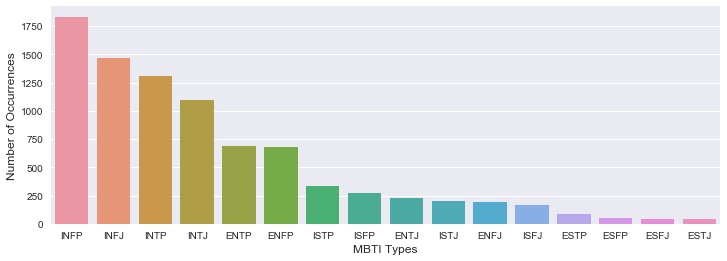

In [14]:
total_rows = data['type'].value_counts()

plt.figure(figsize=(12,4))
sns.barplot(total_rows.index, total_rows.values, alpha=1)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('MBTI Types', fontsize=12)
plt.savefig('MBTI_types_barchart.png', dpi=100)
plt.show()

In [17]:
data.iloc[0]

id                                                       1
type                                                  INFJ
posts    http://www.youtube.com/watch?v=qsXHcwe3krw|||h...
Name: 0, dtype: object

In [117]:
def sentence_and_words(text):
    cachedStopWords = stopwords.words("english")
    
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()

    words = ""
    line = 0
    total_words = 0
    
    for item in text.split('|||'):
        sentence = item.strip()
        sentence = re.sub("[^a-zA-Z]", " ", sentence)
        sentence = re.sub(' +', ' ', sentence).lower()
        
        if sentence and len(sentence) > 1:
            line += 1
            
            new_words = [stemmer.stem(lemmatizer.lemmatize(w.strip())) for w in sentence.split(' ') 
                         if w.strip() not in cachedStopWords and len(w.strip()) > 1]
            
            total_words += len(new_words)
            words += " ".join([w for w in new_words])
            #print(new_words)
    return line, total_words, words

In [130]:
data['sentences'] = 0
data['total_words'] = 0
data['total_urls'] = 0
data['words'] = 0

total_rows = len(data)

for i in range(total_rows):
    mbti_type = data.iloc[i]['type']
    text = data.iloc[i]['posts']
    
    urls = re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',  text)
    text = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', text)
    
    total_sentence, total_words, words = sentence_and_words(text)
    #print(words)
    data.loc[data.index == i, 'sentences'] = total_sentence
    data.loc[data.index == i, 'total_words'] = total_words
    data.loc[data.index == i, 'total_urls'] = len(urls)
    data.loc[data.index == i, 'words'] = words

In [136]:
summary = pd.DataFrame(columns = ['MBTI Type', 'Average Sentences', 'Average Words', 'Average URLs'])
#summary.columns = ['MBTI Type', 'Average Sentences', 'Average Words', 'Average URLs']

# Group by the mbti type and describe the basic summary
groups = data.groupby('type')

i = 0
for g, gdf in groups:
    row = []
    
    row.append(g)
    row.append(np.rint(gdf['sentences'].sum() / gdf['sentences'].count()).astype(int))
    row.append(np.rint(gdf['total_words'].sum() / gdf['total_words'].count()).astype(int))
    row.append(np.rint(gdf['total_urls'].sum() / gdf['total_urls'].count()).astype(int))
    
    summary.loc[i] = row
    
    i += 1

In [137]:
summary

,MBTI Type,Average Sentences,Average Words,Average URLs
0,ENFJ,48,620,3
1,ENFP,47,613,3
2,ENTJ,48,598,3
3,ENTP,48,595,2
4,ESFJ,47,628,1
5,ESFP,44,495,3
6,ESTJ,48,599,3
7,ESTP,47,576,3
8,INFJ,47,621,3
9,INFP,47,607,4


### Basic functionality for generating confusion matrix

In [186]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [187]:
mbti_types = ['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP',
       'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ']

mbti_types_encoder = LabelEncoder().fit(mbti_types)

# Classification model - Naive Bayes 

In [311]:
all_data = sklearn.utils.shuffle(data).reset_index(drop=True)
all_data = sklearn.utils.shuffle(all_data).reset_index(drop=True)
all_data = sklearn.utils.shuffle(all_data).reset_index(drop=True)

all_data = all_data[['type', 'posts', 'sentences', 'total_words', 'words', 'total_urls']]

length = len(all_data)
train_data_len = np.floor(length * 0.8).astype(int)

train_data = all_data.head(train_data_len)
test_data = all_data.tail(length - train_data_len)

In [313]:
len(train_data)

6940

In [314]:
len(test_data)

1735

### Initializing a couter for each of the MBTI category

In [195]:
mbti_types = train_data['type'].unique()
mbti_counter = dict()

for mbti_type in mbti_types:
    mbti_counter[mbti_type] = Counter()

### Calculating the counts of each token

In [196]:
n = len(train_data)
for i in range(n):
    #if i > 5:
    #    break    
    tokens = re.findall(r"[\w']+", train_data.iloc[i]['words'])    
    mbti_counter[train_data.iloc[i]['type']].update(tokens)

### Calculate the class probability

In [197]:
class_prob = {}
total = len(train_data)
for mbti_type in mbti_types:
    class_prob[mbti_type] = np.log(train_data[train_data['type'] == mbti_type]['type'].count() / total)

### Calculate the feature probability

In [198]:
feature_prob = {}
alpha = 1.0
num_classes = len(train_data['type'].unique())
for mbti_type in mbti_types:
    total = sum(mbti_counter[mbti_type].values())
    prob = {}
    for token in mbti_counter[mbti_type]:
        prob[token] = np.log((alpha + mbti_counter[mbti_type][token]) / (total + num_classes * alpha))
    feature_prob[mbti_type] = prob

### Setting up the model

In [199]:
model = {}
model['class_prob'] = class_prob
model['feature_prob'] = feature_prob

### Prediction using the trained model

In [200]:
def naive_bayes_predict(example, model):
    
    tokens = re.findall(r"[\w']+", example)
    
    min_prob = 0
    min_label = ''
    
    for mbti_type in mbti_types:
        prob = 1.0
        for token in tokens:
            token_prob = 1.0
            try:
                token_prob = model['feature_prob'][mbti_type][token]
            except KeyError:
                token_prob = 1.0

            prob = prob + token_prob
        prob += model['class_prob'][mbti_type]

        if prob < min_prob:
            min_prob = prob
            min_label = mbti_type
    
    return min_label

#test_data = pd.DataFrame.from_csv('mbti_1.csv')
#test_data = test_data.sample(frac=0.1).reset_index(drop=True)

labels = []
n = len(test_data)
for i in range(n):
    label = naive_bayes_predict(test_data.iloc[i]['words'], model)
    labels.append(label)

### Accuracy of the Naive Bayes prediction model

In [201]:
actual_labels = test_data['type'].tolist()
total = 0
for i in range(len(labels)):
    if actual_labels[i] == labels[i]:
        total += 1
print(total / len(labels))

0.16820276497695852


### Confusion matrix

Confusion matrix


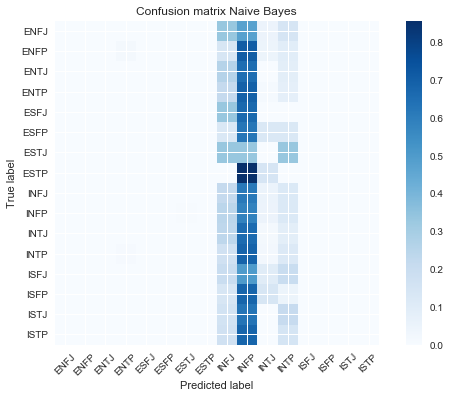

In [406]:
cnf_matrix = metrics.confusion_matrix(actual_labels, labels)
np.set_printoptions(precision=2)
# Plot confusion matrix
plt.figure(3)
#fig_i += 1
plot_confusion_matrix(cnf_matrix, classes=mbti_types_encoder.inverse_transform(range(16)), normalize=True,
                                          title=('Confusion matrix Naive Bayes'))
plt.savefig('confusion_matrix_naive_bayes.png', dpi=100)
#plt.savefig('confusion_matrix_naive_bayes.png', bbox_inches='tight', dpi=100)
plt.show()

# Converting the word to vector using gensim model

In [375]:
def word_to_vector(data):
    
    data_vector = []
    length = len(data)
    
    for i in range(length):
        #if i > 0:
         #   break
        test = data.iloc[[i]]
        corpus = test['posts'].values.tolist()
        
        tokenized_corpus = [ nltk.word_tokenize(sent) for sent in corpus ]
        #print(tokenized_corpus)
        unique_words = set(tokenized_corpus[0])
        #for word in tokenized_corpus[0]:
            #if len(word) > 2:
            #unique_words.add(word)

        gmodel = gensim.models.Word2Vec(tokenized_corpus, min_count = 1, size = 32)

        vectors = []
        for word in unique_words:
            if len(word) < 3:
                continue
            vectors.append(gmodel[word])

        avg_vector = np.average(vectors, axis=0)
        data_vector.append(avg_vector)
    
    return np.array(data_vector)

In [380]:
train_matrix = word_to_vector(train_data)

In [376]:
test_matrix = word_to_vector(test_data)

In [381]:
train_matrix.shape

(6940, 32)

In [379]:
test_matrix.shape

(1735, 32)

In [382]:
train_matrix1 = np.hstack((train_matrix, np.asarray(train_data['sentences'].tolist()).reshape(train_matrix.shape[0],1)))
train_matrix1 = np.hstack((train_matrix1, np.asarray(train_data['total_words'].tolist()).reshape(train_matrix1.shape[0],1)))
train_matrix1 = np.hstack((train_matrix1, np.asarray(train_data['total_urls'].tolist()).reshape(train_matrix1.shape[0],1)))

In [383]:
train_matrix1.shape

(6940, 35)

In [384]:
test_matrix1 = np.hstack((test_matrix, np.asarray(test_data['sentences'].tolist()).reshape(test_matrix.shape[0],1)))
test_matrix1 = np.hstack((test_matrix1, np.asarray(test_data['total_words'].tolist()).reshape(test_matrix1.shape[0],1)))
test_matrix1 = np.hstack((test_matrix1, np.asarray(test_data['total_urls'].tolist()).reshape(test_matrix1.shape[0],1)))

In [385]:
test_matrix1.shape

(1735, 35)

In [386]:
train_labels = train_data['type'].tolist()
train_labels = mbti_types_encoder.transform(train_labels)

In [387]:
train_labels.shape

(6940,)

In [388]:
test_labels = test_data['type'].tolist()
test_labels = mbti_types_encoder.transform(test_labels)

In [390]:
test_labels.shape

(1735,)

In [396]:
structures = [[20,6]] #[[10, 3], [20, 6]]#, [30, 9]]
activations = ['logistic',]# 'identity']#['identity', 'logistic', 'tanh', 'relu']
solvers = ['lbfgs']# 'adam']#['lbfgs', 'sgd', 'adam']
alphas = [1e-5]
runs = [1]#, 20, 30, 40, 50]

for structure in structures:
    for activation in activations:
        for solver in solvers:
            for alpha in alphas:
                for run in runs:
                    scores = 0
                    for i in range(run):
                        mlp_model = mlp_wrapper(train_matrix1, train_labels, structure[0], structure[1], 
                                                activation, solver, alpha)
                        predicted_labels = mlp_model.predict(test_matrix1)
                        #score = np.mean(test_labels == predicted_labels)
                        
                        #actual_labels = test_data['type'].tolist()
                        
                        total = 0
                        for i in range(len(test_labels)):
                            if test_labels[i] == predicted_labels[i]:
                                total += 1
                        #print(total / len(test_labels))
                        
                        print('structure(',structure[0], ',',structure[1],'), activation =',activation,', solver = ',solver,
                          ', alpha =',alpha,', total runs =',run,', accuracy =', total / len(test_labels))

structure( 20 , 6 ), activation = logistic , solver =  lbfgs , alpha = 1e-05 , total runs = 1 , accuracy = 0.2011527377521614


Confusion matrix


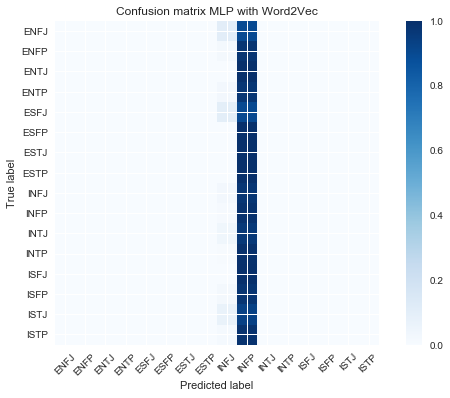

In [407]:
cnf_matrix = metrics.confusion_matrix(test_labels, predicted_labels)
np.set_printoptions(precision=2)
# Plot confusion matrix
plt.figure(2)
#fig_i += 1
plot_confusion_matrix(cnf_matrix, classes=mbti_types_encoder.inverse_transform(range(16)), normalize=True,
                                          title=('Confusion matrix MLP with Word2Vec'))
plt.savefig('confusion_matrix_mlp_word2vec.png', dpi=100)
plt.show()